In [161]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, HeatKernel, Silhouette, BettiCurve, PairwiseDistance, PersistenceImage 
from gtda.plotting import plot_point_cloud
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
from hausdorff import hausdorff_distance
import numpy as np
import pickle as pickle
import gudhi as gd  
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


# Load data

In [121]:
label_list = [1, 3, 5, 7]

In [122]:
# All features
feature_df  = pd.read_csv("Features/All_Features.csv")

In [123]:
# Load embeddings with embedding dimension 3

train_embeddings = {} # dictionary with labels as keys, embeddings of the respective classes as values
test_embeddings = {} # dictionary with labels as keys, embeddings of the respective classes as values

for label in label_list:
    train_embeddings[label] = np.load("Embeddings_and_Persistence_Diagrams/Train_Embeddings_PD"+str(label)+"_Dim3.npy", allow_pickle=True)
    test_embeddings[label] = np.load("Embeddings_and_Persistence_Diagrams/Test_Embeddings_PD"+str(label)+"_Dim3.npy", allow_pickle=True)

In [124]:
# Load shortened_persistence diagrams

train_shortened_persistence_diagrams = {} # dictionary with labels as keys, persistence diagrams of the respective classes as values
test_shortened_persistence_diagrams = {} # dictionary with labels as keys, persistence diagrams of the respective classes as values


for label in label_list:
    train_shortened_persistence_diagrams[label] = np.load("Embeddings_and_Persistence_Diagrams/Train_Shortened_Diagrams"+str(label)+".npy", allow_pickle=True)
    test_shortened_persistence_diagrams[label] = np.load("Embeddings_and_Persistence_Diagrams/Test_Shortened_Diagrams"+str(label)+".npy", allow_pickle=True)


In [125]:
# Load barycenters

wasserstein_barycenters = [] # dictionary with labels as keys, persistence diagrams of the respective classes as values

for label in label_list:
    wasserstein_barycenters.append(np.load('Embeddings_and_Persistence_Diagrams/wasserstein_Barycenter_class_'+\
                                           str(label)+'.npy', allow_pickle=True)[0])
    

# Create simplicial complexes (Experimental)

First, we plot the mean embeddings of each class as point clouds (of which we later want to see the simplicial complexes).

In [126]:
mean_embeddings = {}

for label in label_list:
    all_embeddings = np.concatenate((train_embeddings[label].astype("float"), test_embeddings[label].astype("float")))
    mean_embeddings[label] = np.mean(all_embeddings, axis=0)


In [127]:
# Label 1
plot_point_cloud(mean_embeddings[1])

In [128]:
# Label 3
plot_point_cloud(mean_embeddings[3])

In [129]:
# Label 5
plot_point_cloud(mean_embeddings[5])

In [130]:
# Label 7
plot_point_cloud(mean_embeddings[7])

Now create simplicial complexes (Vietoris-Rips and alpha complexes) and visualize alpha complexes.

In [131]:
# Label 1
# Vietoris-Rips complex
skeleton = gd.RipsComplex(points = mean_embeddings[1], max_edge_length = 0.2)
Rips_simplex_tree_sample = skeleton.create_simplex_tree(max_dimension = 3) 

# alpha complex
ac = gd.AlphaComplex(points=mean_embeddings[1])
st = ac.create_simplex_tree()

points = np.array([ac.get_point(i) for i in range(st.num_vertices())])
# We want to plot the alpha-complex with alpha=0.005 by default.
# We are only going to plot the triangles
triangles = np.array([s[0] for s in st.get_skeleton(2) if len(s[0]) == 3 and s[1] <= 0.005])

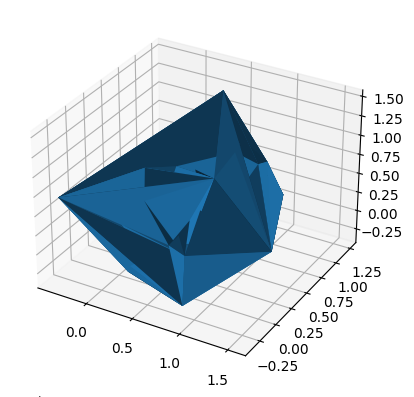

In [132]:
# Visualization with matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# TODO does this have a small scaling?
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
l = ax.plot_trisurf(points[:, 0], points[:, 1], points[:, 2], triangles = triangles)

plt.show()

In [133]:
# Label 7
# Label 1
# Vietoris-Rips complex
skeleton = gd.RipsComplex(points = mean_embeddings[7], max_edge_length = 0.2)
Rips_simplex_tree_sample = skeleton.create_simplex_tree(max_dimension = 3) 

# alpha complex
ac = gd.AlphaComplex(points=mean_embeddings[7])
st = ac.create_simplex_tree()

points = np.array([ac.get_point(i) for i in range(st.num_vertices())])
# We want to plot the alpha-complex with alpha=0.005 by default.
# We are only going to plot the triangles
triangles = np.array([s[0] for s in st.get_skeleton(2) if len(s[0]) == 3 and s[1] <= 0.005])

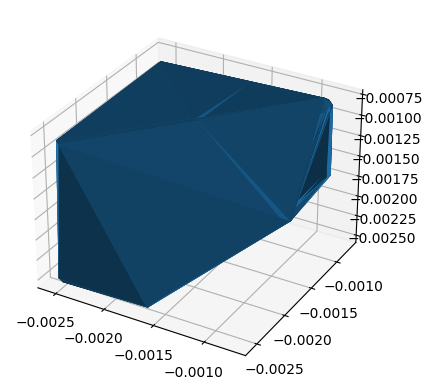

In [134]:
# Visualization with matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
l = ax.plot_trisurf(points[:, 0], points[:, 1], points[:, 2], triangles = triangles)

plt.show()

Different way of visualization:

# Visualizations

## Dissimilarity matrix of barycenters

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/gtda/utils/validation.py:19: FutureWarning:

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.

/Users/piabaronetzky/anaconda3/envs/time-delay-embeddings/lib/python3.10/site-packages/gtda/utils/validation.py:19: FutureWarning:

Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.



<Axes: >

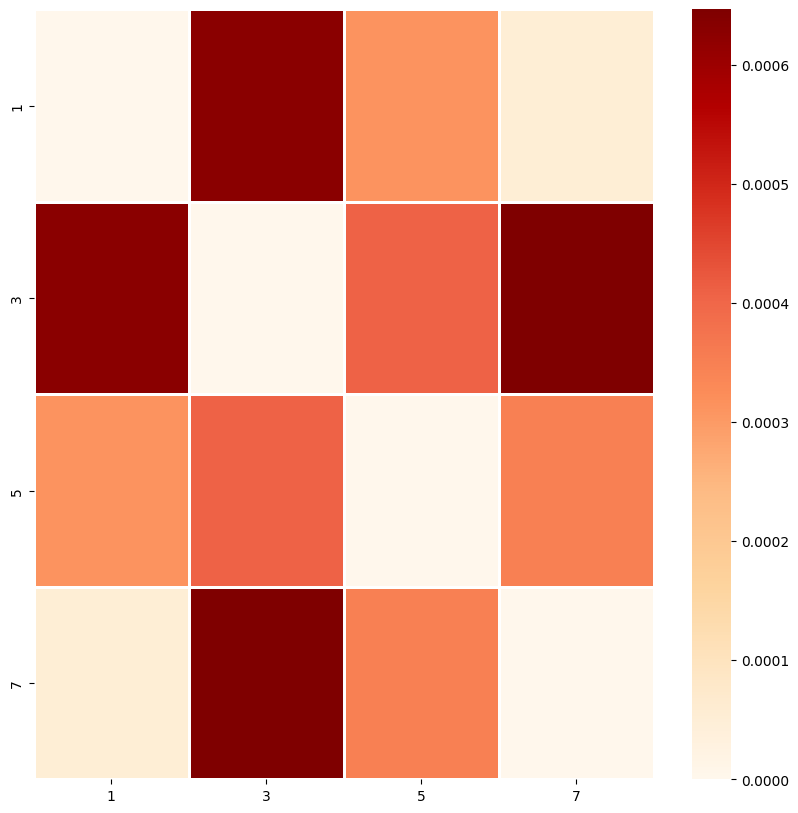

In [135]:
# Wasserstein barycenter
pairwise_distances = PairwiseDistance(metric="wasserstein").fit_transform(wasserstein_barycenters)

# plot it with seaborn
plt.figure(figsize=(10,10))
sns.heatmap(
    pairwise_distances,
    cmap='OrRd',
    linewidth=1,
    xticklabels = [1, 3, 5, 7],
    yticklabels = [1, 3, 5, 7]
)

## Box plots

In [180]:
feature_df.columns

Index(['Unnamed: 0', 'Persistence Entropy_Dim_0', 'Persistence Entropy_Dim_1',
       'Persistence Entropy_Dim_2', 'Amplitude_Dim_0', 'Amplitude_Dim_1',
       'Amplitude_Dim_2', 'No_Points_Dim_0', 'No_Points_Dim_1',
       'No_Points_Dim_2', 'Largest_Persistence_Dim_0',
       'Largest_Persistence_Dim_1', 'Largest_Persistence_Dim_2', 'Mean',
       'Variance', 'Entropy', 'Lumpiness', 'Stability', 'Hurst',
       'STD_Derivative', 'Crossing_Points', 'Binarized_Means',
       'Distance_to_wasserstein_Barycenter1',
       'Distance_to_wasserstein_Barycenter3',
       'Distance_to_wasserstein_Barycenter5',
       'Distance_to_wasserstein_Barycenter7',
       'wasserstein_Distance_to_Origin_Diagram', 'AC_coordinate_cc1',
       'AC_coordinate_cc2', 'AC_coordinate_cc3', 'AC_coordinate_cc4',
       'Distance_to_bottleneck_Barycenter1',
       'Distance_to_bottleneck_Barycenter3',
       'Distance_to_bottleneck_Barycenter5',
       'Distance_to_bottleneck_Barycenter7',
       'bottleneck_Dist

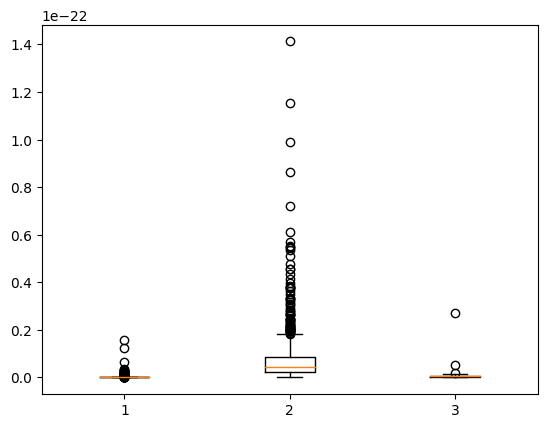

In [183]:
# Choose feature to plot box plot

feature = "AC_coordinate_cc3"

explored_feature = []
explored_feature.append(feature_df[feature][feature_df["Label"] == 1])
explored_feature.append(feature_df[feature][feature_df["Label"] == 3])
explored_feature.append(feature_df[feature][feature_df["Label"] == 5])
#explored_feature.append(feature_df[feature][feature_df["Label"] == 7]) # Changes scaling too much


plt.boxplot(explored_feature)

# show plot
plt.show()

## Heat Kernel

In [140]:
HK = HeatKernel(sigma=0.00003, n_bins=100)

In [141]:
def heat_kernel_intensity(heatkernel, homology_dimension):
    """ Computes mean intensity of a heatkernel. Only takes positive values because otherwise the mean would
      always be zero.

    Parameters:
    - heatkernel (list of lists): heatkernel of all homology dimensions
    - homology_dimension (int): Which homology dimension to look at (0, 1 or 2)

    Returns:
    - mean intensity of heatkernel of homology dimension homology_dimension
    """
    
    positives =  [x for inner_list in heatkernel[0][homology_dimension] for x in inner_list if x > 0]
    
    return np.mean(positives)

### Homology dimension 0

#### Label 1

Heat kernel intensity of label 1 for homology dimension 0: 5076222699.718398


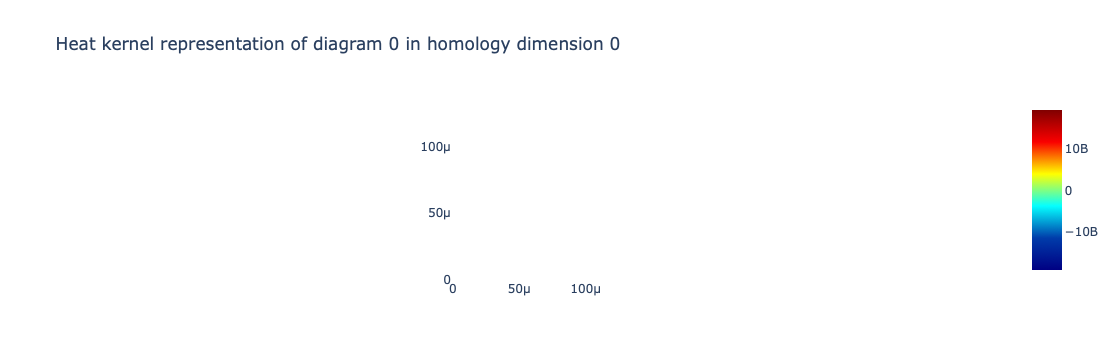

In [142]:
heatkernel = HK.fit_transform(train_shortened_persistence_diagrams[1])
print("Heat kernel intensity of label 1 for homology dimension 0: " + str(heat_kernel_intensity(heatkernel, 0)))
HK.plot(heatkernel, homology_dimension_idx=0, colorscale='jet')

Heat kernel intensity of label 3 for homology dimension 0: 2831856766.7105665


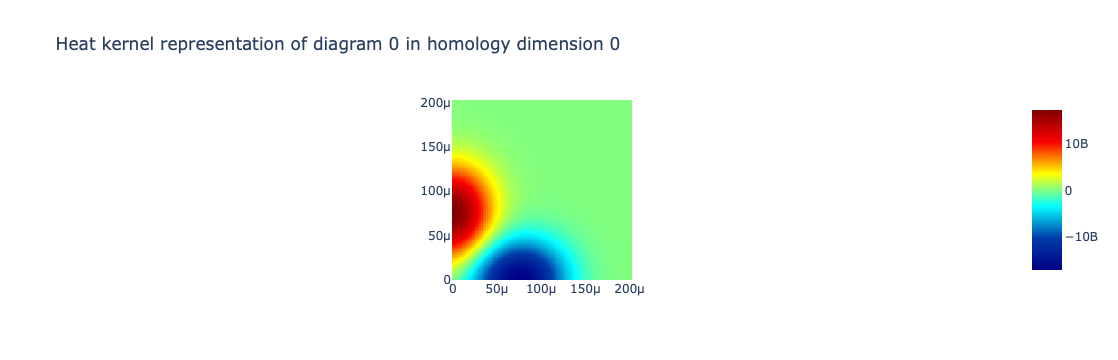

In [143]:
heatkernel = HK.fit_transform(train_shortened_persistence_diagrams[3])
print("Heat kernel intensity of label 3 for homology dimension 0: " + str(heat_kernel_intensity(heatkernel, 0)))
HK.plot(heatkernel, homology_dimension_idx=0, colorscale='jet')

Heat kernel intensity of label 5 for homology dimension 0: 5406393933.382456


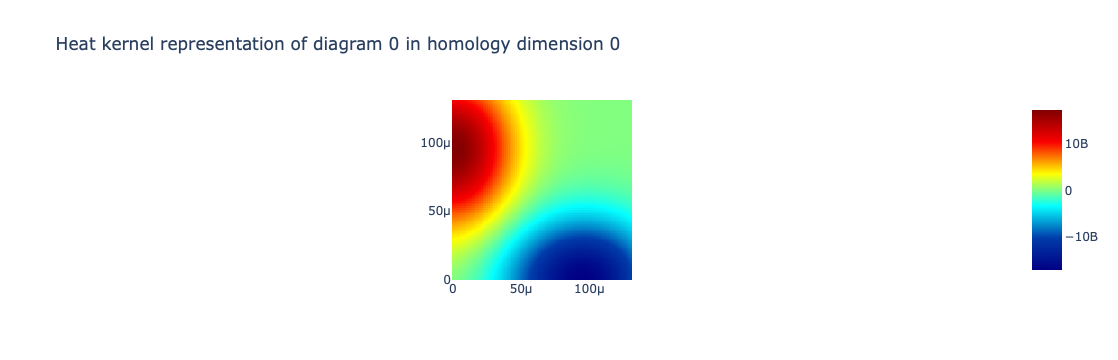

In [144]:
heatkernel = HK.fit_transform(train_shortened_persistence_diagrams[5])
print("Heat kernel intensity of label 5 for homology dimension 0: " + str(heat_kernel_intensity(heatkernel, 0)))

HK.plot(heatkernel, homology_dimension_idx=0, colorscale='jet')

Heat kernel intensity of label 7 for homology dimension 0: 8385554457.545019


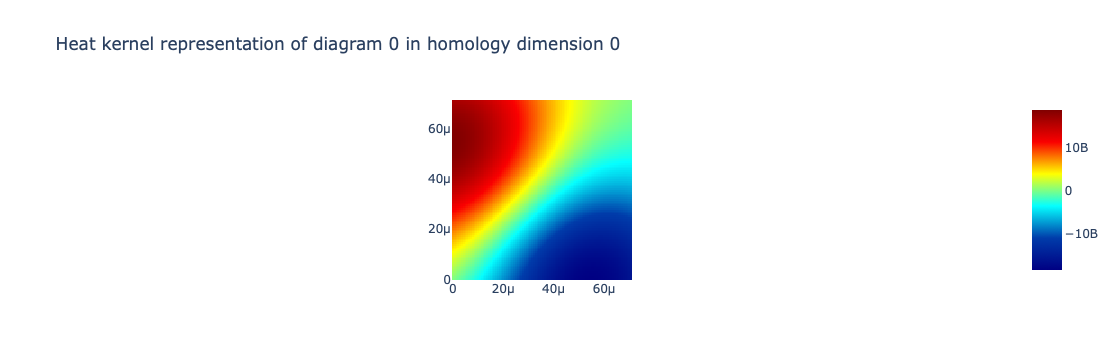

In [145]:
heatkernel = HK.fit_transform(train_shortened_persistence_diagrams[7])
print("Heat kernel intensity of label 7 for homology dimension 0: " + str(heat_kernel_intensity(heatkernel, 0)))

HK.plot(heatkernel, homology_dimension_idx=0, colorscale='jet')

# Persistence Landscape

In [146]:
PL = PersistenceLandscape()


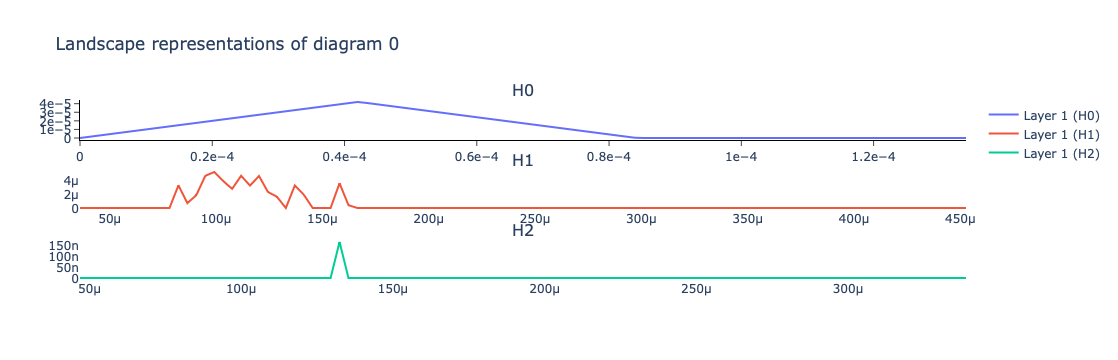

In [147]:
landscape = PL.fit_transform(train_shortened_persistence_diagrams[1])
PL.plot(landscape)

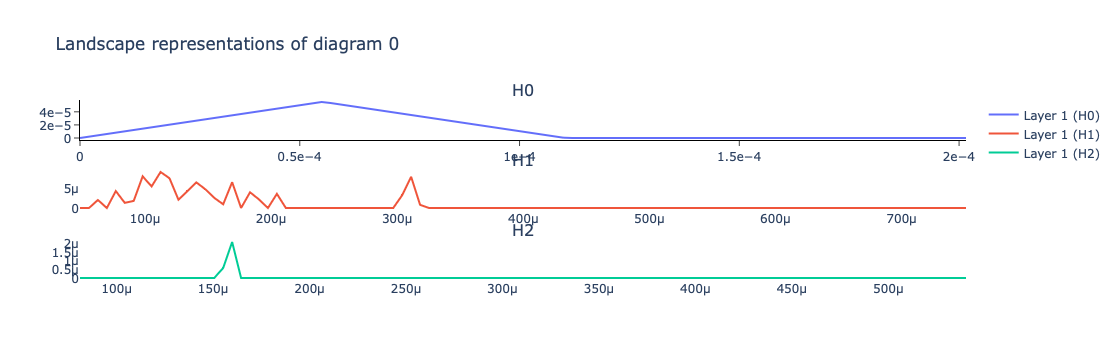

In [148]:
landscape = PL.fit_transform(train_shortened_persistence_diagrams[3])
PL.plot(landscape)

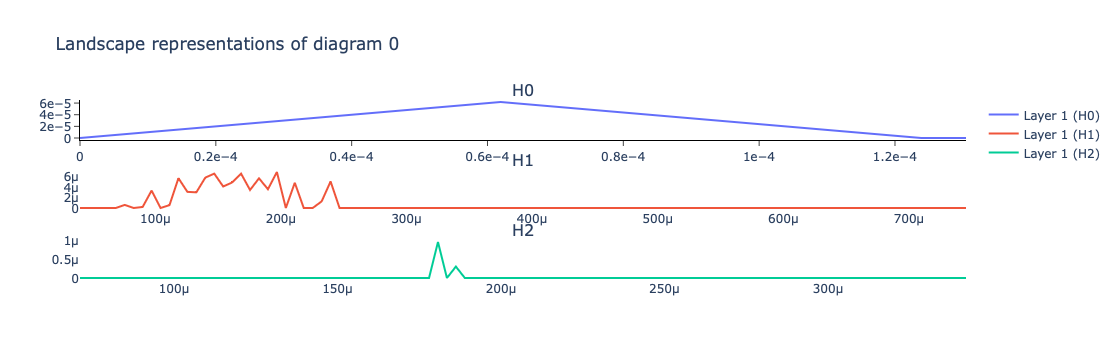

In [149]:
landscape = PL.fit_transform(train_shortened_persistence_diagrams[5])
PL.plot(landscape)


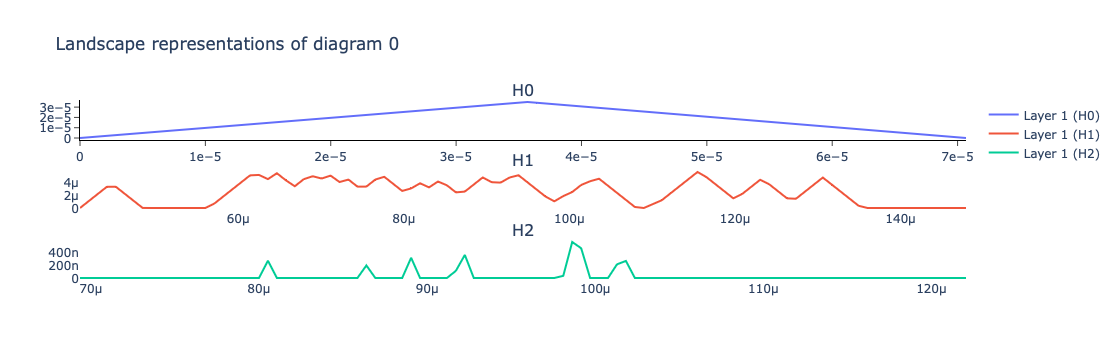

In [150]:
landscape = PL.fit_transform(train_shortened_persistence_diagrams[7])
PL.plot(landscape)

# Silhouette

In [151]:
SH = Silhouette()


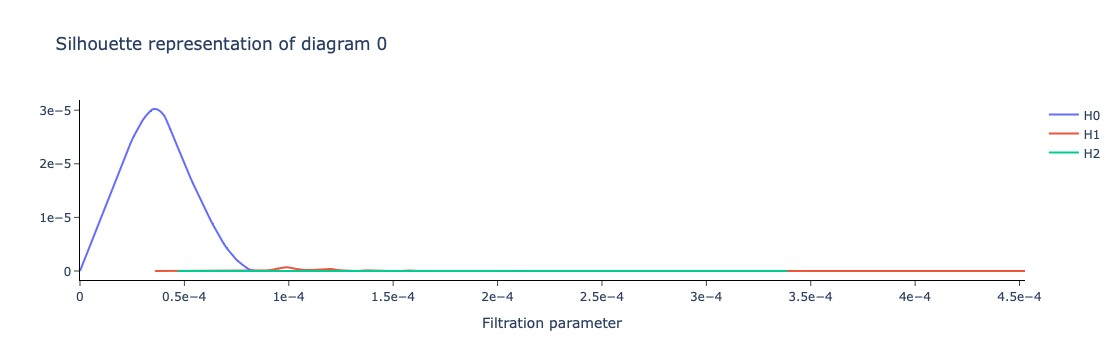

In [152]:
silhouette = SH.fit_transform(train_shortened_persistence_diagrams[1])

SH.plot(silhouette, homology_dimensions = [0, 1, 2])

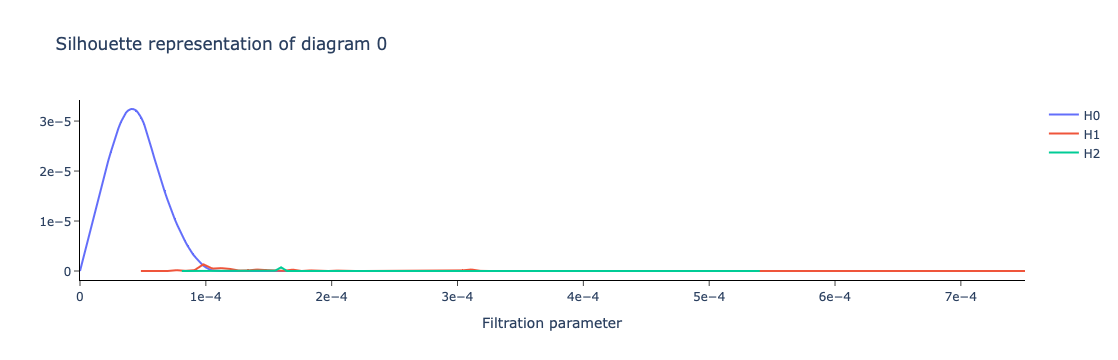

In [153]:
silhouette = SH.fit_transform(train_shortened_persistence_diagrams[3])

SH.plot(silhouette, homology_dimensions = [0, 1, 2])

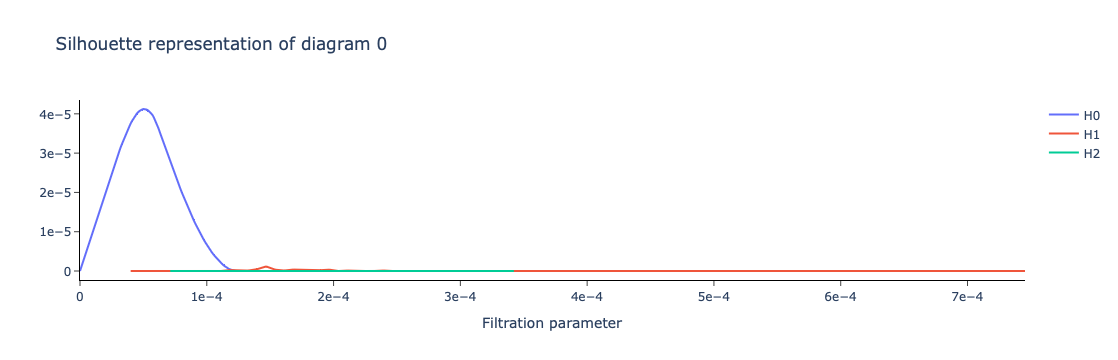

In [154]:
silhouette = SH.fit_transform(train_shortened_persistence_diagrams[5])

SH.plot(silhouette, homology_dimensions = [0, 1, 2])

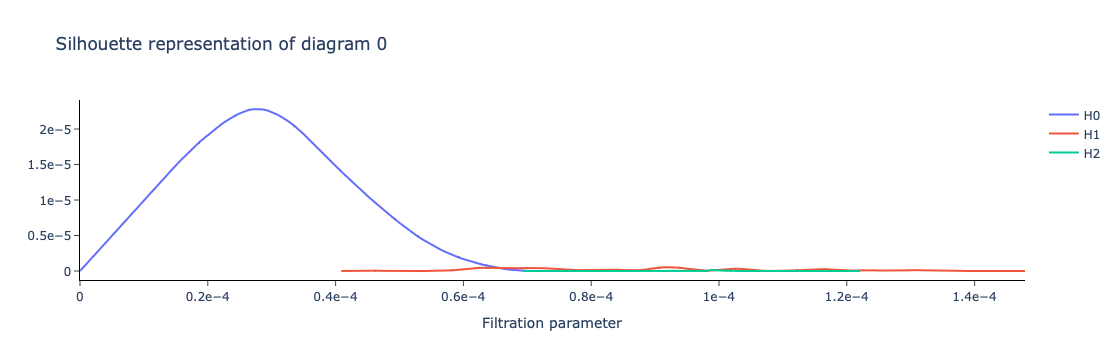

In [155]:
silhouette = SH.fit_transform(train_shortened_persistence_diagrams[7])

SH.plot(silhouette, homology_dimensions = [0, 1, 2])

# Betti Curve

In [156]:
BC = BettiCurve()


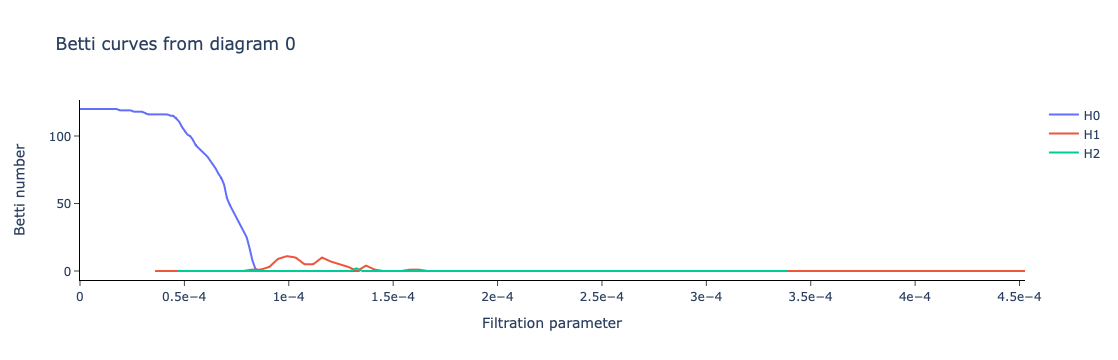

In [157]:
betti_curve = BC.fit_transform_plot(train_shortened_persistence_diagrams[1])

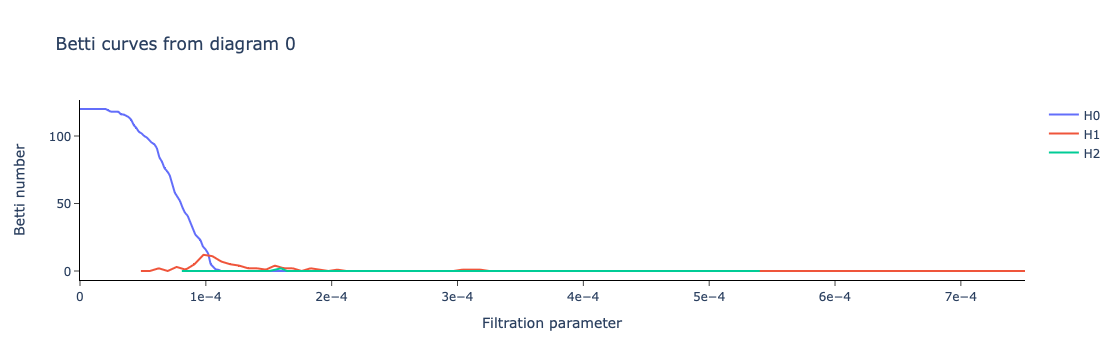

In [158]:
betti_curve = BC.fit_transform_plot(train_shortened_persistence_diagrams[3])

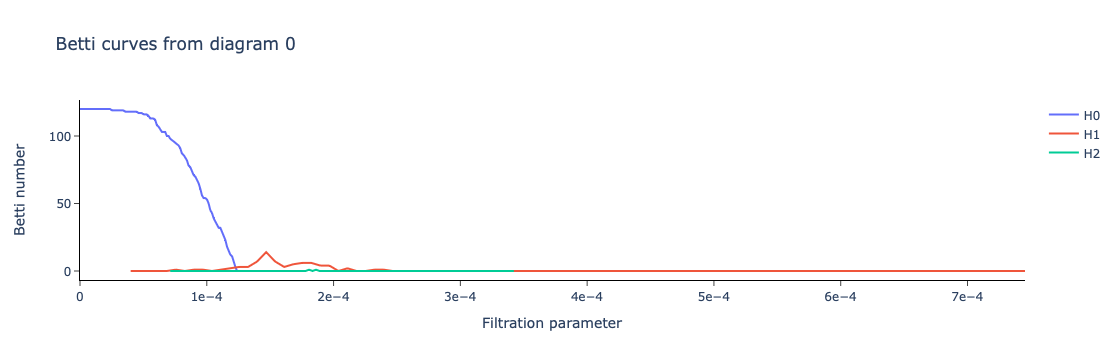

In [159]:
betti_curve = BC.fit_transform_plot(train_shortened_persistence_diagrams[5])

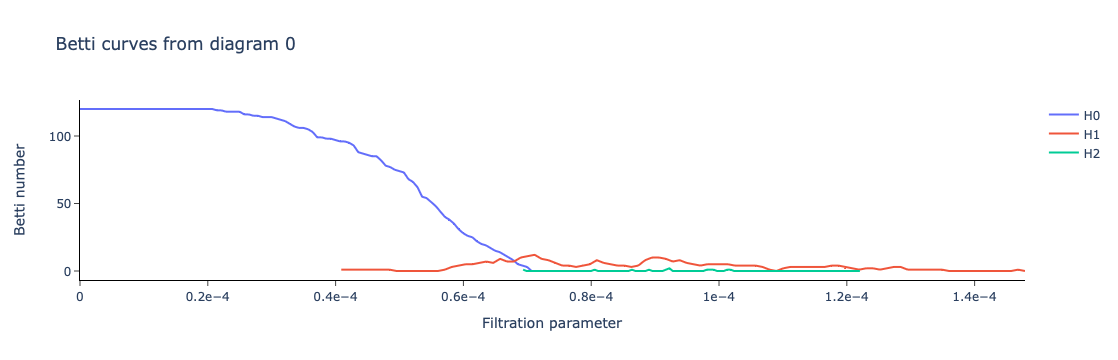

In [160]:
betti_curve = BC.fit_transform_plot(train_shortened_persistence_diagrams[7])

# Persistence Images

In [163]:
PI = PersistenceImage()

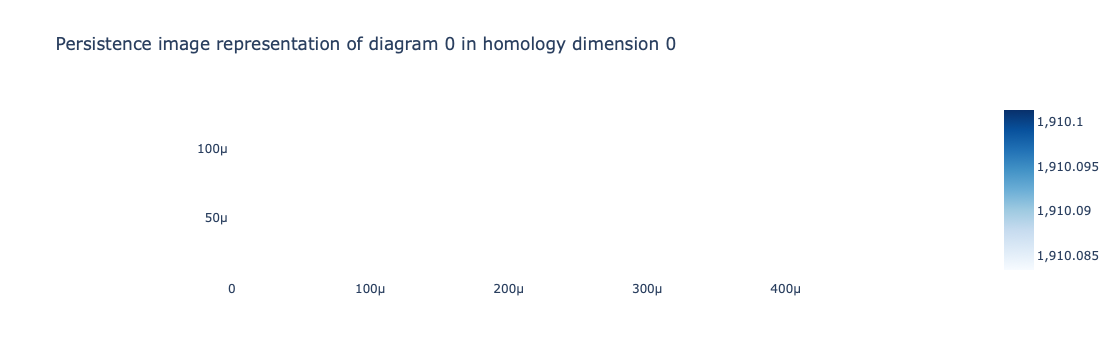

In [164]:
persistence_image = PI.fit_transform_plot(train_shortened_persistence_diagrams[1])